In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np
from lime import explanation
from lime import lime_base
import math

In [3]:
import time_series_explainer.ts_explainer as ts_explainer

In [4]:
class TimeSeriesKNN:
    def __init__(self, **kwargs):
        self.knn = KNN(**kwargs)

    def fit(self, X: np.array, y: np.array):
        self.size = min([arr.shape[1] for arr in X])

        self.knn.fit([arr[:, : self.size].ravel() for arr in X], y)

    def predict(self, X: np.array):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.knn.predict([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.knn.predict(X.ravel()[None, :])

    def predict_proba(self, X):
        if isinstance(X, list) or len(X.shape) == 3:
            return self.knn.predict_proba([arr[:, : self.size].ravel() for arr in X])
        else:
            return self.knn.predict_proba(X.ravel()[None, :])

## Load ECG Dataset

In [5]:
ecg_train = pd.read_csv('./data/ECG/ecg_train.csv', sep=',', header=None).astype(float)
ecg_train = ecg_train.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

ecg_test = pd.read_csv('./data/ECG/ecg_test.csv', sep=',', header=None).astype(float)
ecg_test = ecg_test.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

ecg_train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639
0,1.0,-1.100900,-1.136300,-0.269700,-0.287390,-0.252010,-0.216640,-0.181270,-0.163590,-0.092842,...,-0.234330,-0.252010,-0.30507,-0.393500,-0.499620,-0.588040,-0.658790,-0.747220,-0.871020,-1.030200
1,3.0,0.277960,0.293750,0.323010,0.312740,0.266580,0.233220,0.243510,0.256340,0.225550,...,0.250930,0.276540,0.28621,0.267300,0.245100,0.224670,0.200620,0.208800,0.257250,0.284180
2,4.0,-0.259780,-0.257880,-0.258900,-0.248390,-0.227680,-0.229630,-0.252780,-0.256260,-0.256170,...,-0.258200,-0.259100,-0.25693,-0.239240,-0.227960,-0.234630,-0.235500,-0.228220,-0.236620,-0.254950
3,3.0,-0.100410,-0.068534,-0.051683,-0.066385,-0.089782,-0.084242,-0.056820,-0.056761,-0.080574,...,-0.169920,-0.178470,-0.16660,-0.145190,-0.129140,-0.160310,-0.201710,-0.175870,-0.125520,-0.112450
4,3.0,0.083505,0.079466,0.075540,0.083133,0.079600,0.061685,0.060065,0.078609,0.095152,...,0.003916,0.023833,0.05540,0.079133,0.073154,0.057730,0.056222,0.056939,0.057024,0.070183
5,3.0,0.072670,0.076435,0.076485,0.090557,0.086567,0.046026,0.012847,0.014216,0.026656,...,0.127090,0.118980,0.10371,0.094120,0.085277,0.069814,0.060452,0.061074,0.058219,0.059693
6,2.0,-0.113750,-0.115630,-0.118750,-0.119070,-0.116960,-0.117660,-0.121440,-0.122170,-0.119210,...,-0.114060,-0.119260,-0.12399,-0.126470,-0.126280,-0.122400,-0.116560,-0.113230,-0.113490,-0.113940
7,4.0,-0.247380,-0.246970,-0.247230,-0.247440,-0.246830,-0.247260,-0.247730,-0.246260,-0.247390,...,-0.253360,-0.252690,-0.25356,-0.253650,-0.249780,-0.246500,-0.247050,-0.247540,-0.246940,-0.247190
8,4.0,0.294820,0.292790,0.301290,0.306000,0.304860,0.310870,0.316790,0.316150,0.318160,...,0.323880,0.316560,0.32099,0.330520,0.326950,0.317160,0.319340,0.326990,0.322450,0.307610
9,2.0,-0.115490,-0.121800,-0.124060,-0.123490,-0.124740,-0.128550,-0.132740,-0.136280,-0.137930,...,-0.125280,-0.121760,-0.12446,-0.125990,-0.121990,-0.118120,-0.118200,-0.117720,-0.113740,-0.111410


In [7]:
ecg_test_x = ecg_test.loc[:, 1:].to_numpy()[:, None, :]
ecg_test_y = ecg_test.loc[:, 0].astype(int)

ecg_train_x = ecg_train.loc[:, 1:ecg_test_x.shape[2]].to_numpy()[:, None, :]
ecg_train_y = ecg_train.loc[:, 0].astype(int)
ecg_test_y  -= 1
ecg_train_y -= 1

## Datasets

Let's plot the two time series datasets using different colors for each class.

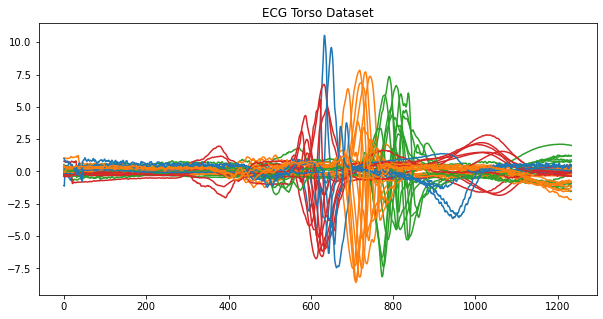

In [9]:
plt.figure(figsize = (10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx in range(0, len(ecg_train)):
    if ecg_train_y[idx] == 0:
        plt.plot(ecg_train_x[idx, 0, :], colors[0], label="#0")
    elif ecg_train_y[idx] == 1:
        plt.plot(ecg_train_x[idx, 0, :], colors[1], label="#1")
    elif ecg_train_y[idx] == 2:
        plt.plot(ecg_train_x[idx, 0, :], colors[2], label="#2")
    elif ecg_train_y[idx] == 3:
        plt.plot(ecg_train_x[idx, 0, :],  colors[3], label="#3")
plt.title('ECG Torso Dataset')
plt.show()

### Compute Accuracy

We train a kNN classifier on that data and print the accuracy. We want to explain this classifier using LIME.

In [10]:
knn = TimeSeriesKNN()
knn.fit(ecg_train_x, ecg_train_y)
print('Accuracy KNN for earthquake dataset: %f' % (acc(ecg_test_y, knn.predict(ecg_test_x))))

Accuracy KNN for earthquake dataset: 0.797872


## Explaining ECG Dataset

In [24]:
idx = 101 # explained instance
num_features = 5 # how many feature contained in explanation
num_slices = 15 # split time series
inst = ecg_test_x[idx]
inst_label = ecg_test_y[idx]

In [25]:
inst.shape, inst_label

((1, 1234), 2)

In [26]:
print(knn.predict_proba(inst))
label = np.argmax(knn.predict_proba(inst))

[[0.  0.2 0.8 0. ]]


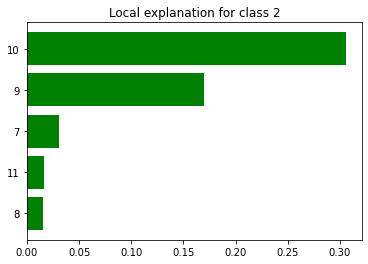

In [41]:
explainer = ts_explainer.LimeTimeSeriesExplainer(knn.predict_proba, metric="jaccard", replacement_method="random")
#explainer = ts_explainer.ShapTimeSeriesExplainer(knn.predict_proba, ecg_train_x, replacement_method="dataset_mean")
exp = explainer.explain_instance(inst, 
                                 labels=[0, 1, 2, 3], # для каких классов будет проводиться оценка "важности" 
                                 num_features=num_features, 
                                 num_samples=10000, 
                                 num_slices=num_slices,
                                )
exp.as_pyplot_figure(label=inst_label)
pass

In [42]:
exp.as_list(label=inst_label)

[(10, 0.3056786845655209),
 (9, 0.16963281181444476),
 (7, 0.030308927812151554),
 (11, 0.016129057879062866),
 (8, 0.015476010906551227)]

[(10, 1.0), (9, 0.531203930564231), (7, 0.05111226825922066), (11, 0.00225031342502056), (8, 0.0)]


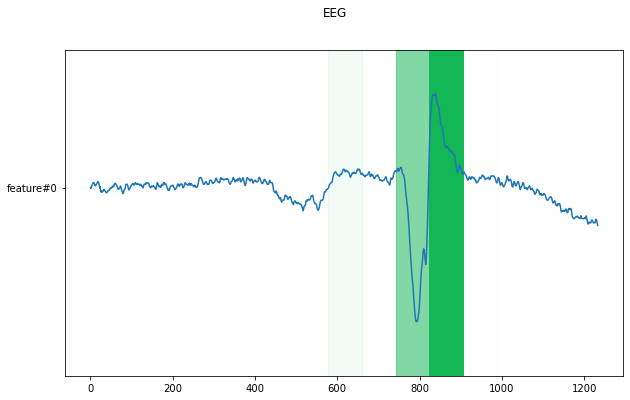

In [43]:
explanations = exp.as_list(label=inst_label)
max_exp = max([abs(x[1]) for x in explanations])
min_exp = min([abs(x[1]) for x in explanations])

def map_to_0_1(x, mx, mn):
    sgn = np.sign(x)
    return sgn * (abs(x) - mn)/(mx - mn)

# привожуобъяснения к отрезку [0, 1] (их модули), чтобы использовать их как alpha канал
explanations = [(x[0], map_to_0_1(x[1], max_exp, min_exp)) for x in explanations]

print(explanations)
ts_explainer.plot_eeg(inst,
                      num_slices,
                      explanations,
                      title="EEG",
                      figsize=(10, 6),
                      positive_color="#13B755",
                      negative_color="#ff0d57")
plt.show()

In [44]:
functor = lambda num_slices: explainer.explain_instance(
                                inst, 
                                labels=[0,1,2,3],
                                num_features=num_slices, 
                                num_samples=5000, 
                                num_slices=num_slices
                                )
cumulative_explanation = ts_explainer.cumulative_explanation(inst, 
                                                             3, 
                                                             functor, 
                                                             np.arange(2, 20))

In [45]:
explanations = cumulative_explanation[0]
max_exp = max(explanations, key=lambda x: abs(x[1]))[1]
min_exp = min(explanations, key=lambda x: abs(x[1]))[1]

def map_to_0_1(x, mx, mn):
    sgn = np.sign(x)
    return sgn * ((abs(x) - mn)/(mx - mn) * 0.6 + 0.2)

explanations = [(x[0], map_to_0_1(x[1], max_exp, min_exp)) for x in explanations]

print(explanations)

[(0, -0.05985347623186074), (1, -0.055640322289719435), (2, -0.0542280711608239), (3, -0.07386171980324924), (4, -0.1147664201032345), (5, -0.16309299254176532), (6, -0.11461501027624378), (7, -0.06869155768338683), (8, -0.008871453426052), (9, 0.08080052456037651), (10, 0.09779455461057379), (11, 0.2631894272109721), (12, 0.4369070074582348), (13, 0.08363385697480058), (14, 0.12075139984421535), (15, -0.023413178250604155), (16, -0.007424734372961095), (17, 0.10852740877891809), (18, 0.1626300936418404)]


(<Figure size 720x432 with 1 Axes>, [<AxesSubplot:>])

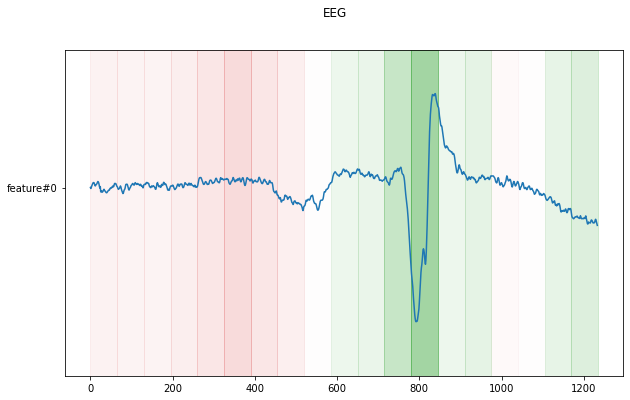

In [46]:
ts_explainer.plot_eeg(inst, 19, explanations, title="EEG", figsize=(10, 6))